## Model  y > $x^2$ as positive and y <= $x^2$ as negative

In [1]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np

from pathlib import Path
from collections import Counter
import os
import re

In [2]:
# ! tar -xvf aclImdb_v1.tar -C data

In [3]:
# Here we generate some fake data
def gen_fake_data(n):
    x = np.random.uniform(0,1,n) 
    y = x**2
    return x, y

x, y = gen_fake_data(500)

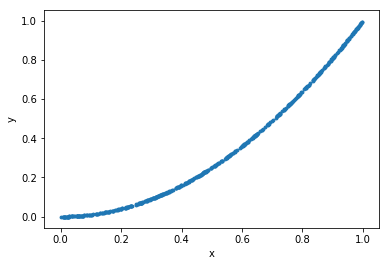

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y");

In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,1)
)

# generating fake data
# Here we generate some fake data


def gen_nn_fake_data(n):
    x = np.random.uniform(-2,2, (n,2))
    y = x[:,1] > x[:,0]**2
    return x, y.astype(int)

x, y = gen_nn_fake_data(5000)

#### Shape of the function

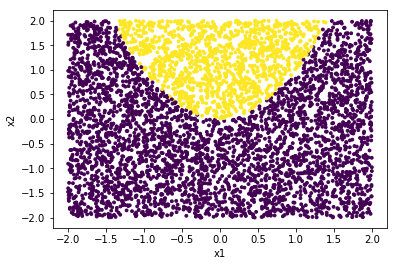

In [11]:
import matplotlib.pyplot as plt
plt.scatter(x[:,0], x[:,1], s=8, c=y );
plt.xlabel("x1"); 
plt.ylabel("x2");

In [12]:
x = np.random.uniform(-2,2, (1000,2))
torch.from_numpy(x).shape

torch.Size([1000, 2])

#### Dataset and Dataloader

In [13]:
def gen_fake_data(n):
    x = np.random.uniform(-2,2, (n,2))
    y = x[:,1] > x[:,0]**2
    return x, y.astype(int)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

# create a dataset
class Classify_Dataset(Dataset):
    def __init__(self, n=100000):
        x, y = gen_fake_data(n)
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
# create a dataset
class Classify_Dataset_test(Dataset):
    def __init__(self, n=10000):
        x, y = gen_fake_data(n)
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    
fake_dataset = Classify_Dataset()
fake_dataset_test = Classify_Dataset_test()

In [14]:
train_dataloader = DataLoader(fake_dataset, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(fake_dataset_test, batch_size=1000, shuffle=True)
x, y = next(iter(train_dataloader))

In [15]:
x.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [16]:
len(train_dataloader), len(test_dataloader)

(100, 10)

#### Create model

In [17]:
# equivalent way of specifiying the same model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(2, 100)
        self.lin2 = nn.Linear(100,1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x 
model =  Model()

In [98]:
model.parameters

<bound method Module.parameters of Model(
  (lin1): Linear(in_features=2, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=1, bias=True)
)>

#### Define learning rate and optimizer

In [18]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
for t in range(200):
    for i, (x, y) in enumerate(train_dataloader): 
        model.train()
        x,y = x.float(), y.float()
        y_hat = model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(1))
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if t % 50 == 0: print(loss.item())

0.05686972290277481
0.0026621411088854074
0.0008410945301875472
0.0029783849604427814


#### Predict for test

In [29]:
y_list = []
y_pred = []
for i, (x, y) in enumerate(test_dataloader): 
    model.eval()
    x,y = x.float(), y.float()
    y_hat = model(x)
    y_hat = sigmoid(y_hat.squeeze(1).data.numpy())
    y_hat = y_hat > 0
    y_hat = y_hat.astype(int)
    y_list.extend(y)
    y_pred.extend(y_hat)

In [39]:
y_list = np.array([int(p) for p in y_list])
y_pred = np.array([int(p) for p in y_pred])
acc = sum(y_list == y_pred)/len(y_list)
print(f'The test accuracy for 200 epochs for our sample data is : {acc}')

The test accuracy for 200 epochs for our sample data is : 0.884


#### Test data ideal

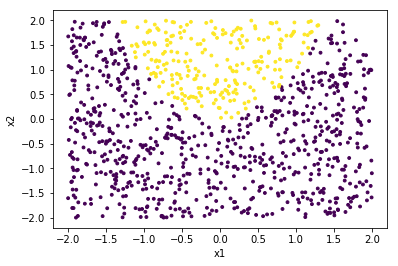

In [40]:
import matplotlib.pyplot as plt
plt.scatter(x[:,0], x[:,1], s=8, c=y );
plt.xlabel("x1"); 
plt.ylabel("x2");

#### Test data predicted

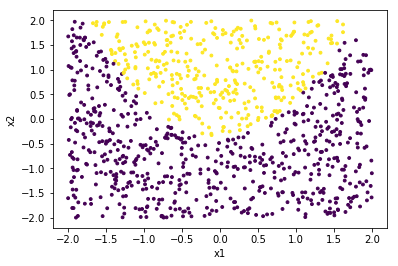

In [41]:
import matplotlib.pyplot as plt
plt.scatter(x[:,0], x[:,1], s=8, c=y_hat );
plt.xlabel("x1"); 
plt.ylabel("x2");

## Q3 CBOW

### Load and read data

In [108]:
# ! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-02-23 14:53:01--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  1.35MB/s    in 1m 48s  

2019-02-23 14:54:48 (764 KB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [110]:
# ! gunzip aclImdb_v1.tar.gz

In [257]:
os.getcwd()

'/home/jupyter'

In [258]:
list(PATH.iterdir())

[PosixPath('data/aclImdb/test'),
 PosixPath('data/aclImdb/train'),
 PosixPath('data/aclImdb/imdbEr.txt'),
 PosixPath('data/aclImdb/imdb.vocab'),
 PosixPath('data/aclImdb/README')]

In [259]:
path = PATH/"train/pos/0_9.txt"
path.read_text()

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

### Tokenization

In [260]:
# !python3 -m spacy download en

In [261]:
import spacy
re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
def sub_br(x): return re_br.sub("\n", x.lower())

my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(sub_br(x))]

In [262]:
PATH = Path("data/aclImdb/")

In [263]:
path = PATH/"train/pos/0_9.txt"
spacy_tok(path.read_text())[:10]

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', '.', 'it', 'ran', 'at']

### Computing vocab2index

In [264]:
pos_files = list((PATH/"train"/"pos").iterdir())
neg_files = list((PATH/"train"/"neg").iterdir())
all_files = pos_files + neg_files
all_files[:3]

[PosixPath('data/aclImdb/train/pos/4080_10.txt'),
 PosixPath('data/aclImdb/train/pos/6864_7.txt'),
 PosixPath('data/aclImdb/train/pos/2107_7.txt')]

In [265]:
counts = Counter()
for path in all_files:
    counts.update(spacy_tok(path.read_text()))

In [266]:
len(counts.keys())

87130

In [267]:
for word in list(counts):
    if counts[word] < 5:
        del counts[word]

In [268]:
len(counts.keys())

29370

#### Create index for words 

In [269]:
vocab2index = {"<PAD>":0, "UNK":1}
words = ["<PAD>", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [270]:
len(words)

29372

#### Encode documents - 400 words per document

In [271]:
# you could imprive this function by taking a random sample
# when sentences are longer than N=400 words 
def encode_sentence_v1(path, vocab2index, N=400):
    x = spacy_tok(path.read_text())
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in x])
    l = min(N, len(enc1))
    enc[N-l:] = enc1[:l]
    return enc

In [272]:
path = PATH/"train/neg/211_4.txt"
encode_sentence_v1(path, vocab2index, N=400)

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
       10608,  1252,    35,  1419,    35,   237,    46,   284,     5,
         300,  3733,   121,   167,  1281,   126,  3084,   200,   293,
         718,    52,  3470, 11387,    52,  9405,    15,  2888,   770,
          15, 12124,    27,  2643,   110,  1180,    46,  3677,   223,
           6, 22966,

#### Create dataset and dataloader

In [273]:
class ImdbDatasetv1(Dataset):
    def __init__(self, PATH, train="train", N=400):
        self.N = N
        self.path_to_images = PATH/train
        self.pos_files = list((self.path_to_images/"pos").iterdir())
        self.neg_files = list((self.path_to_images/"neg").iterdir())
        self.files = self.pos_files + self.neg_files
        # pos 1, neg 0
        self.y = np.concatenate((np.ones(len(self.pos_files), dtype=int),
                                np.zeros(len(self.neg_files), dtype=int)), axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        return encode_sentence_v1(path, vocab2index, self.N), self.y[idx]

In [274]:
train_ds_v1 = ImdbDatasetv1(PATH)
test_ds_v1 = ImdbDatasetv1(PATH, "test")

In [275]:
batch_size = 1000
train_dl_v1 = DataLoader(train_ds_v1, batch_size=batch_size, shuffle=True)
test_dl_v1 = DataLoader(test_ds_v1, batch_size=batch_size)

#### Model 1:  No dropout , Embed size = 100

In [283]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_size=100):
        super(CBOW, self).__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.linear = nn.Linear(emb_size, 1)
        
    def forward(self, x, s):
        x = self.wordJ_emb(x)
        x = x.sum(dim=1)/ s.view(s.shape[0], 1)
        x = self.linear(x)
        return x

In [215]:
model = CBOW(vocab_size= len(words) , emb_size= 50).cuda()

In [32]:
batch_size = 1000
train_dl = DataLoader(train_ds_v1, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds_v1, batch_size=batch_size)

In [37]:
s = torch.FloatTensor([3, 2])
s.view(s.shape[0], 1)

tensor([[3.],
        [2.]])

In [202]:
lr = 0.01
epochs = 1
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)
for i in range(epochs):
    model.train()
    sum_loss = 0.0
    total = 0
    for x, y in train_dl:
        batch = y.shape[0]

        x = x.long().cuda()
        y = y.float().cuda().unsqueeze(1)
        s = torch.tensor([(p!=0).sum() for p in x], dtype=torch.float)
        s = s.cuda().unsqueeze(1)
        y_hat = model(x, s)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        sum_loss += batch*(loss.item())
        total += batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    print("train loss", sum_loss/total)


0.6997334957122803
train loss 0.6997334957122803


In [198]:
model(x, s).sum(dim=1).shape, s.shape

(torch.Size([1000, 3]), torch.Size([1000]))

In [216]:
def train_epocs(model, train_dl, test_dl, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in train_dl:
            batch = y.shape[0]
            
            x = x.long().cuda()
            y = y.float().cuda().unsqueeze(1)
            s = torch.tensor([(p!=0).sum() for p in x], dtype=torch.float)
            s = s.cuda().unsqueeze(1)
            y_hat = model(x, s)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            sum_loss += batch*(loss.item())
            total += batch
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        print("train loss", sum_loss/total)
        test_metrics(model, test_dl)

In [217]:
def test_metrics(model, test_dl):
    model.eval()
    correct = 0
    total_correct = 0
    total = 0
    sum_loss = 0.0
    for x, y in test_dl:
        x = x.long().cuda()
        y = y.float().cuda().unsqueeze(1)
        batch = y.shape[0]
        s = torch.tensor([(p!=0).sum() for p in x], dtype=torch.float)
        s = s.cuda()
        y_hat = model(x, s)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        sum_loss += batch*(loss.item())
        total += batch
        
        y_pred = y_hat > 0
        correct = (y_pred.float() == y).float().sum()
        total_correct += correct
        accuracy = correct/y_pred.shape[0]
        
    print("test loss %.3f and accuracy %.3f" % (sum_loss/total, total_correct/total))



In [218]:
test_metrics(model, test_dl)

test loss 0.699 and accuracy 0.500


In [219]:
train_epocs(model, train_dl, test_dl, epochs=5 , lr=0.01)

train loss 0.6899541234970092
test loss 0.683 and accuracy 0.588
train loss 0.6671959495544434
test loss 0.654 and accuracy 0.703
train loss 0.6241262817382812
test loss 0.608 and accuracy 0.748
train loss 0.5663448071479797
test loss 0.556 and accuracy 0.776
train loss 0.5059348154067993
test loss 0.507 and accuracy 0.799


In [220]:
train_epocs(model, train_dl, test_dl, epochs=5 , lr=0.01)

train loss 0.45746511936187745
test loss 0.474 and accuracy 0.814
train loss 0.41922646403312686
test loss 0.445 and accuracy 0.824
train loss 0.385453382730484
test loss 0.420 and accuracy 0.834
train loss 0.35616311311721804
test loss 0.399 and accuracy 0.840
train loss 0.33082845211029055
test loss 0.382 and accuracy 0.846


In [221]:
train_epocs(model, train_dl, test_dl, epochs=5 , lr=0.05)

train loss 0.28356166899204255
test loss 0.327 and accuracy 0.865
train loss 0.21086047291755677
test loss 0.304 and accuracy 0.874
train loss 0.1660961902141571
test loss 0.298 and accuracy 0.877
train loss 0.13381591200828552
test loss 0.303 and accuracy 0.876
train loss 0.10794114381074905
test loss 0.316 and accuracy 0.873


> * We see that the model above is overfitting since there is a significant gap between train and test. We will use dropout in the next model

#### Model 2 : With dropout and Embedding size =10

In [231]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_size=100):
        super(CBOW, self).__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.linear = nn.Linear(emb_size, 1)
        self.dp = nn.Dropout(0.6)
        
    def forward(self, x, s):
        x = self.word_emb(x)
        x = x.sum(dim=1)/ s.view(s.shape[0], 1)
        x = self.dp(x)
        x = self.linear(x)
        return x

model = CBOW(vocab_size= len(words) , emb_size= 10).cuda()

batch_size = 1000
train_dl = DataLoader(train_ds_v1, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds_v1, batch_size=batch_size)

In [232]:
test_metrics(model, test_dl)

test loss 0.695 and accuracy 0.500


In [233]:
train_epocs(model, train_dl, test_dl, epochs=5 , lr=0.05)

train loss 0.6257010734081269
test loss 0.488 and accuracy 0.794
train loss 0.39537338733673094
test loss 0.339 and accuracy 0.858
train loss 0.2838129323720932
test loss 0.301 and accuracy 0.874
train loss 0.22911015212535857
test loss 0.295 and accuracy 0.878
train loss 0.19157327592372894
test loss 0.297 and accuracy 0.880


In [234]:
train_epocs(model, train_dl, test_dl, epochs=5 , lr=0.01)

train loss 0.16597280979156495
test loss 0.301 and accuracy 0.880
train loss 0.1583275717496872
test loss 0.304 and accuracy 0.881
train loss 0.1489512526988983
test loss 0.309 and accuracy 0.880
train loss 0.14543037742376327
test loss 0.315 and accuracy 0.878
train loss 0.1382785564661026
test loss 0.319 and accuracy 0.878


>* This model still has overfitting. Probably the number of features is less

#### Model 3 - Without drop and increase embedding size back to 50

In [284]:
def train_epocs(model, train_dl, test_dl, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in train_dl:
            batch = y.shape[0]
            
            x = x.long().cuda()
            y = y.float().cuda().unsqueeze(1)
            s = torch.tensor([(p!=0).sum() for p in x], dtype=torch.float)
            s = s.cuda().unsqueeze(1)
            y_hat = model(x, s)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            sum_loss += batch*(loss.item())
            total += batch
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        print("train loss", sum_loss/total)
        test_metrics(model, test_dl)

In [291]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_size=100):
        super(CBOW, self).__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.linear = nn.Linear(emb_size, 1)
#         self.dp = nn.Dropout(0.6)
        
    def forward(self, x, s):
        x = self.word_emb(x)
        x = x.sum(dim=1)/ s.view(s.shape[0], 1)
#         x = self.dp(x)
        x = self.linear(x)
        return x

model = CBOW(vocab_size= len(words) , emb_size= 50).cuda()

batch_size = 1000
train_dl = DataLoader(train_ds_v1, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds_v1, batch_size=batch_size)

In [292]:
test_metrics(model, test_dl)

test loss 0.694 and accuracy 0.501


In [293]:
train_epocs(model, train_dl, test_dl, epochs=5 , lr=0.1)

train loss 0.693251416683197
test loss 0.692 and accuracy 0.508
train loss 0.6920679092407227
test loss 0.691 and accuracy 0.528
train loss 0.6912714219093323
test loss 0.691 and accuracy 0.544
train loss 0.6905511832237243
test loss 0.690 and accuracy 0.556
train loss 0.6898566389083862
test loss 0.689 and accuracy 0.563


In [294]:
train_epocs(model, train_dl, test_dl, epochs=5 , lr=1)

train loss 0.6866023373603821
test loss 0.683 and accuracy 0.594
train loss 0.6807597064971924
test loss 0.678 and accuracy 0.610
train loss 0.6756936573982238
test loss 0.673 and accuracy 0.621
train loss 0.6712911677360535
test loss 0.669 and accuracy 0.615
train loss 0.6672965264320374
test loss 0.665 and accuracy 0.627


In [245]:
train_epocs(model, train_dl, test_dl, epochs=5 , lr=1)

train loss 0.685180344581604


KeyboardInterrupt: 

>* This model''s accuracy increases continuous, however it is slow. We will stop here. 
* Probably the embedding learnt are not generalizable/ the vocabulary is very high for us to learn with a model like CBOW